#  Kickstarter Projects - How to Invest Safely

## 1.)  What is Kickstarter?  What's to Gain from Analyzing its Data?

$ Kickstarter $ is a crowdfunding site where you can make contributions to fund your favorite projects. In return, if these projects meet their goals, they send out rewards based on the tiered amount you donated.  If you give me $ \$20 $, I'll give you my mixtape when it drops.  If you give me $\$50$, I'll sign it for you.  And if you give me $\$500$, I'll put your name in a song. 

A few of my friends are big supporters of the projects on the site, and they've amassed some pretty cool swag in return.  I've recently been tempted to join in, but can't help but worry that 

Data from 209,222 projects downloaded from https://webrobots.io/kickstarter-datasets/.  This dataset provides many useful features, including campaign goal, duration, success/failure, category/subcategory, location, title, and associated URLS.

In future analysis, I hope to scrape further to include #images/videos, reward tier system, full project description, etc.

## 2.)  Hypothesis and Strategy


    1 The higher the goal the less of a chance a project has of success.
    2 Certain categories (like Board Games) are more popular with larger communities, leading to marginally higher success rates among the more popular categories (I'm betting this will win out over market saturation).
    3 Campaigns will be more successful at certain times (like in December leading up to Christmas).
    4 The more content a campaign has, the better it will do.

The plan is to dive into the data using visualizations, create any additional features that may inform predictions, and create/train a model to predict whether a campaign with specified features will be successful or not.  

## 3.) Getting Started - Import Libraries, Basic Preprocessing

Data from 209,222 Kickstarter projects.  Data is scraped monthly and placed into a CSV for that given month.  Data can be downloaded from https://webrobots.io/kickstarter-datasets/ (last checked March 2019).

### Imported libraries for data loading, processing, training, and evaluation

In [410]:
## ETL / Data Loading and Transforming ##
import numpy as np
import pandas as pd
from scipy import stats
import glob
import datetime as dt
import json
from ast import literal_eval

## Tools for Data Visualization ##
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('muted')
%matplotlib inline

## Finally, for final Data Preparation, Model Training, and Model Evaluation ##
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

# Store of various parameters used to improve plotting in this notebook #
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

plt.style.use('ggplot')
rcParams['font.size'] = 12

for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)

In [3]:
## Specifying path to 56 CSV files and loading them all into a single dataframe (~GB) ##

path = r'./Kickstarter Data/Kickstarter_2019-03-14T03_20_12_200Z'

campaigns = pd.concat((pd.read_csv(file) for file in glob.glob(path + "/*.csv")))

## A first look at our dataframe ##
campaigns.head(2)

,backers_count,blurb,category,converted_pledged_amount,country,created_at,creator,currency,currency_symbol,currency_trailing_code,...,slug,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_pledged,usd_type
0,21,2006 was almost 7 years ago.... Can you believ...,"{""id"":43,""name"":""Rock"",""slug"":""music/rock"",""po...",802,US,1387659690,"{""id"":1495925645,""name"":""Daniel"",""is_registere...",USD,$,True,...,new-final-round-album,https://www.kickstarter.com/discover/categorie...,True,False,successful,1391899046,1.0,"{""web"":{""project"":""https://www.kickstarter.com...",802.0,international
1,97,An adorable fantasy enamel pin series of princ...,"{""id"":54,""name"":""Mixed Media"",""slug"":""art/mixe...",2259,US,1549659768,"{""id"":1175589980,""name"":""Katherine"",""slug"":""fr...",USD,$,True,...,princess-pals-enamel-pin-series,https://www.kickstarter.com/discover/categorie...,True,False,successful,1551801611,1.0,"{""web"":{""project"":""https://www.kickstarter.com...",2259.0,international


<br>
By examining the statistics of each column, we can get a better idea of how widely varying the data is and what specific information we have access to.  Columns like 'category' and 'creator' are dictionaries encoded in strings that we will have to process.  We can see where and when each project originated, its overall goal, and how much it raised.

We'll be predicting project success which is encoded in the 'state' column.
<br>
<br>

In [4]:
campaigns.describe()

,backers_count,converted_pledged_amount,created_at,deadline,fx_rate,goal,id,launched_at,pledged,state_changed_at,static_usd_rate,usd_pledged
count,209222.000000,2.092220e+05,2.092220e+05,2.092220e+05,209222.000000,2.092220e+05,2.092220e+05,2.092220e+05,2.092220e+05,2.092220e+05,209222.000000,2.092220e+05
mean,145.419057,1.289290e+04,1.456089e+09,1.463033e+09,0.994857,4.917604e+04,1.073222e+09,1.460206e+09,1.881403e+04,1.462838e+09,1.010757,1.289213e+04
std,885.967976,8.889414e+04,6.339711e+07,6.305618e+07,0.211654,1.179427e+06,6.198051e+08,6.309029e+07,3.229596e+05,6.290421e+07,0.231893,8.890124e+04
min,0.000000,0.000000e+00,1.240366e+09,1.241334e+09,0.008966,1.000000e-02,8.624000e+03,1.240603e+09,0.000000e+00,1.241334e+09,0.008771,0.000000e+00
25%,4.000000,1.060000e+02,1.413317e+09,1.420607e+09,1.000000,1.500000e+03,5.351054e+08,1.417639e+09,1.100000e+02,1.420485e+09,1.000000,1.060014e+02
50%,27.000000,1.537000e+03,1.457895e+09,1.464754e+09,1.000000,5.000000e+03,1.074579e+09,1.461924e+09,1.556000e+03,1.464709e+09,1.000000,1.537358e+03
75%,89.000000,6.548000e+03,1.511595e+09,1.519437e+09,1.000000,1.500000e+04,1.609369e+09,1.516694e+09,6.887200e+03,1.519366e+09,1.000000,6.550000e+03
max,105857.000000,8.596474e+06,1.552527e+09,1.557721e+09,1.876033,1.000000e+08,2.147476e+09,1.552537e+09,8.103074e+07,1.552537e+09,1.716408,8.596475e+06


In [5]:
print('The initial columns in our dataframe are: \n \n', list(campaigns.columns))

The initial columns in our dataframe are: 
 
 ['backers_count', 'blurb', 'category', 'converted_pledged_amount', 'country', 'created_at', 'creator', 'currency', 'currency_symbol', 'currency_trailing_code', 'current_currency', 'deadline', 'disable_communication', 'friends', 'fx_rate', 'goal', 'id', 'is_backing', 'is_starrable', 'is_starred', 'launched_at', 'location', 'name', 'permissions', 'photo', 'pledged', 'profile', 'slug', 'source_url', 'spotlight', 'staff_pick', 'state', 'state_changed_at', 'static_usd_rate', 'urls', 'usd_pledged', 'usd_type']


## 4.)  Basic Data Processing

Workshopping the following columns: 

    1.)  Times are in UNIX format and must be converted to datetime
    2.)  Category, location, and creator_id must be extracted from JSON Dict ~ '{contents}'
           --> Can read string to get dict, but unexpected ""s in entries need to be dealt with separately. 

Note row 350 (id 1455233479) initially gave me a world of hurt because of "Kat "NomadiKat" Vallera".  Anyone who uses a nickname with quotes messes up the field.  Thanks Kat \*__\*

In [6]:
## Create duration column for number of days project had to acquire goal.  Convert UNIX to normal datetime. ##

campaigns['duration'] = pd.to_datetime(campaigns['deadline'], unit='s').sub(\
    pd.to_datetime(campaigns['launched_at'], unit='s')).dt.days

For now, I'll assign poorly behaved creator entries a creator_id of 0.  Will be easy enough to correct later if I so choose, but since most creators are unique (157k/209k not counting the 0's), they will not be able to differentiate between the different classes we're trying to predict, and thus won't be useful in our analysis to first order.

<br>

With this assignment, we're ready to parse the creator column into useable columns that correspond to the Subcategory ID of a Kickstarter campaign and its corresponding Parent ID.

In [7]:
good_indicies = []
bad_indicies = []

for i in range(len(campaigns)):
    try:
        good_indicies.append(json.loads(campaigns['creator'].values[i])['id'])
    except ValueError:
        bad_indicies.append(i)
    else:
        continue
        
campaigns['creator'].iloc[bad_indicies] = '{"id": 0}'

campaigns['creator_id'] = campaigns['creator'].map(lambda x: json.loads(x)['id'])

## Quickly viewing creators associated with multiple projects. ##
(campaigns[campaigns['creator_id'] != 0].groupby(by = 'creator_id', as_index=True, group_keys=True))['id'].count().sort_values(ascending=False).head(5)

creator_id
2104052526    76
1655558466    61
957058942     59
2039317553    56
1323060510    55
Name: id, dtype: int64

Now, extract other relevant information from dataframe, populating new columns that describe where and when a campaign was launched:

<br>

In [61]:
training_rough = campaigns.copy()

# Rename the 'state' column as 'status' to clear name for location states coming in later #
training_rough.rename(columns={'state' : 'status'}, inplace=True)

# Read in the dictionaries stored in the ID column and unpack.  Try/Except block used to handle #
# problematic ID entries, such as when names have additional "" that inhibit loading as json #
training_rough['sub_id'] = training_rough['category'].map(lambda x: json.loads(x)['id'])
list_of_dicts = training_rough['category'].apply(lambda x: eval(x))

parent_ids = []
rogue_indices = []

for i in range(len(list_of_dicts)):
    try:
        elem = list_of_dicts.ravel()[i]
        parent_ids.append(elem['parent_id'])
    except KeyError:
        rogue_indices.append(i)
        parent_ids.append(0)
    else:
        continue
        
training_rough = training_rough.assign(parent_id = parent_ids)

In [62]:
# Add location history to training dataframe #
training_rough['location'].fillna(value='{"name":"Unknown", "state": "Unknown"}', inplace=True)
training_rough['city'] = training_rough['location'].map(lambda x: json.loads(x)['name'])
training_rough['state'] = training_rough['location'].map(lambda x: json.loads(x)['state'])

# Add time information to training dataframe #
dates = pd.to_datetime(training_rough['launched_at'], unit='s')
training_rough['weekday_launched'] = dates.map(lambda x: x.weekday())
training_rough['month_launched'] = dates.map(lambda x: x.month)
training_rough['year_launched'] = dates.map(lambda x: x.year)
training_rough['quarter'] = dates.map(lambda x: x.quarter)

# Create a new column that keeps track of the number of words in each blurb #
training_rough['blurb'].fillna(value='None', inplace=True)
training_rough['num_words'] = training_rough['blurb'].map(lambda x: len(x.split()))

#### Out with the old, in with the new

In the last line above, I added reduced the blurb to a basic but useful feature: the number of words in the blurb.  I could include other columns such as blurb sentiment and complexity (based on syllable per word count) but will leave them out at present.
<br>

Having extracted the information I'm interested in from the parent columns, it is now time to drop them.  But I will also add two columns that I expect to be useful in data visualization: the fraction of the funding goal raised for each campaign and the effective daily goal to meet success:

In [64]:
kickstarter = training_rough.copy()

cols_to_keep = ['id', 'goal', 'backers_count', 'duration', 'creator_id', 'status', 'usd_pledged', 'quarter',\
                'parent_id', 'sub_id', 'num_words', 'city', 'state', 'weekday_launched', 'year_launched',\
                'spotlight', 'staff_pick', 'month_launched']

kickstarter = kickstarter[cols_to_keep]
kickstarter = kickstarter.drop_duplicates('id', keep='last')
kickstarter.set_index('id', inplace=True)

kickstarter['funding_fraction'] = kickstarter['usd_pledged'].div(kickstarter['goal'])
kickstarter['daily_goal'] = kickstarter['goal'].div(kickstarter['duration'])

## 5.) Preamble to Visualization

<br>
Let's try to visualize project success based on various available features.  Though the main priority is to investigate feature relationships with project succcess, we should also investigate the distribution and trend of the underlying features over time.  This will help us to assess whether a single model can be constructed over the entirety of the available data or whether the system needs to be analyzed as a time series.  Consideration of how dynamic the underlying features are will also help to inform how an aggregate model might drift.

<br>



### Defining a few convenient functions


Since I wish to predict whether a specific campaign will succeed or not, it will be useful to examine the data in terms of success rate.  I construct a few helper functions that I'll use throughout.

In [336]:
def success_rate(df, col):
    
    """ {DataFrame, column} -> {Series}
    
    Takes in a dataframe and the column you wish to sort by and returns the rate of success for each value in that column.
    
    """
    
    mask_of_success = (df['status'] == 'successful')
    successes = df[mask_of_success]
    
    success_by_col = successes.goal.groupby(successes[col]).count()
    total_by_col = df.goal.groupby(df[col]).count()
    
    success_rate = []
    items = success_by_col.index
    
    for item in items:
        try:
            rate = success_by_col[item] / total_by_col[item]
            success_rate.append(100*rate)
        except KeyError:
            rate = 1
        
    success_rate = pd.Series(success_rate, index=items)
    
    return success_rate

In [355]:
def turn_off_spines(axis):
    
    """Disables all spines for a given plot axis.
    """

    return axis.spines["top"].set_visible(False), axis.spines["bottom"].set_visible(False),\
axis.spines["right"].set_visible(False), axis.spines["left"].set_visible(False)  

<br>
A quick glance at the distribution of key features can help to inform where interesting dependencies may lie.  This also allows us to anticipate which features need cleaning and normalization later (the importance of this will depend on which algorithm we choose to learn the problem).

In [426]:
# Taking a subset of the features from the Kickstarter DataFrame #
interesting_feats_df = kickstarter.loc[:, ['goal', 'duration', 'parent_id', 'num_words', 'funding_fraction', 'status', 'usd_pledged', 'sub_id']]
interesting_feats_df.loc[interesting_feats_df['funding_fraction'] > 4, 'funding_fraction'] = 4
interesting_feats_df['goal'] = np.log1p(interesting_feats_df['goal'])
interesting_feats_df['usd_pledged'] = np.log1p(interesting_feats_df['usd_pledged'])

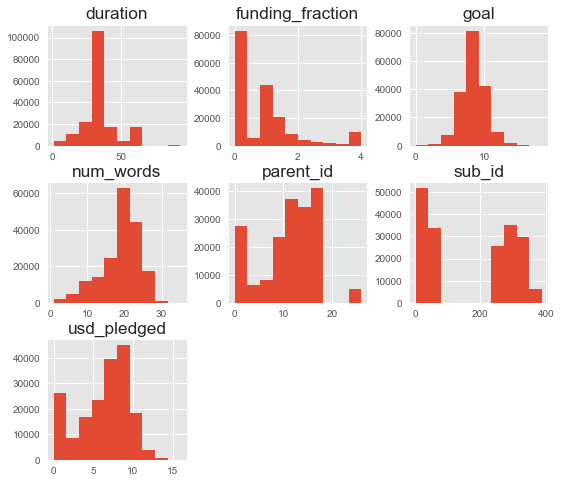

In [427]:
# Examining their distributions (with funding fraction capped for visual purposes) #
interesting_feats_df.hist(figsize=(8,8))
plt.show()

## 6.) Visualizing Kickstarter Campaigns

Now that the data is callable we can dive into exploratory data analysis.  Looking first at how the campaigns have fared overall:

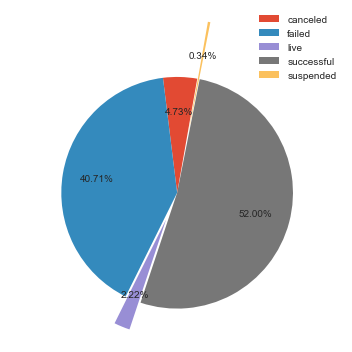

In [171]:
counts = kickstarter.goal.groupby(kickstarter.status).count()
labels = counts.index
pct = 100 * counts / counts.sum()

fig, ax = plt.subplots(figsize=[5,5])
pathces, texts, autotexts = ax.pie(counts, autopct='%1.2f%%', pctdistance=.7, startangle=80, \
                                  explode=[0, 0, .25, 0, .5])

ax.axis('equal')
ax.legend(labels)
plt.tight_layout()
plt.show()

This is higher than expected and what I have seen cited.  However, this is a feature of the scraped dataset that is available, so I'll continue the analysis on this subset and update my model with the new data later.

<br>

#### Project Goal and Project Success
The most obvious intuition to test is whether the funding goal is related to project success.  This is certainly true at some level (nothing is getting funded for $ \$ 1.2 trillion $) and this negative correlation appears to carry over to the range of project goals.  

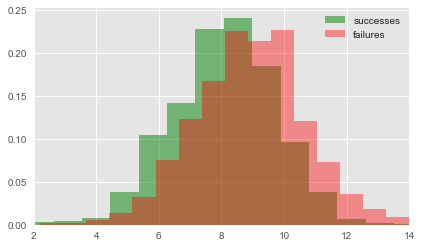

In [409]:
plt.hist(np.log(successes['goal'].values), bins=25, normed=True, alpha=0.5, color='g', label='successes')
plt.hist(np.log(failures['goal'].values), bins=25, normed=True, alpha=0.4, color='r', label='failures')

plt.xlim([2,14])
plt.legend()
plt.show()

These are easily distinct distributions as can be demonstrated with a Bartlett test (used instead of ANOVA / F statistic to show without needing to assume normality).

In [414]:
stats.bartlett(np.log(successes['goal'].values), np.log(failures['goal'].values))

BartlettResult(statistic=765.3095901031103, pvalue=1.8818711543773436e-168)

We see from the above that successful projects have smaller goals.

#### Parent Category and Success

<br>

One might imagine that there the 16 broad parent categories do not appeal equally to those on Kickstarter.  This demonstrates the disparity of success rates between categories and also highlights the large variance in category volume

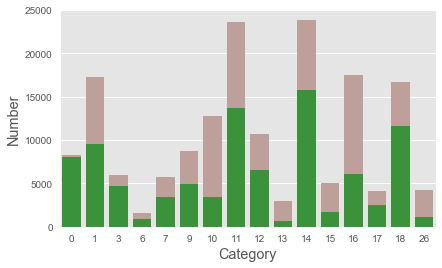

In [341]:
fig, ax1 = plt.subplots()
labels = success_by_category.index

p1 = sns.barplot(x=labels, y=success_by_category, color=tableau20[4])
p2 = sns.barplot(x=labels, y=failure_by_category, bottom=success_by_category, color=tableau20[11])

plt.ylabel('Number')
plt.xlabel('Category')

plt.show()

#### Funding Fraction Distribution by Success

It could be interesting to move beyond a binary measure of success.  I do so with the measure 'funding fraction,' which is the ratio of the amount a campaign has raised over their initial goal.  The visualizations below suggest that projects that fail most often completely fail, struggling to make it to the 10 $\%$ mark.  Interestingly, we can see a small bump around the 70% mark, suggesting projects receive a small surge of support if they are near success.

<br>

This is further suggested by the large peak of projects receiving just enough funding.  The tail for the successful project distribution does not decay as quickly, perhaps a consequence of late purchasing of rewards by those who essentially order a product from a successful campaign.

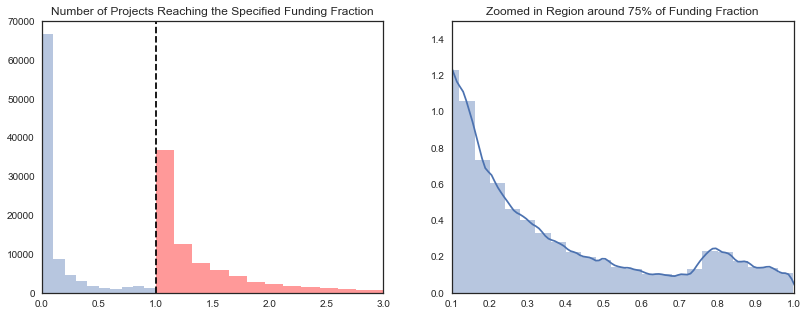

In [343]:
plt.style.use('seaborn')
plt.style.use('seaborn-white')

fig, ax = plt.subplots(1, 2, figsize=(12,5))

# Color in blue the funding fraction histogram of projects that did not meet their goal of 1.0 #
sns.distplot(kickstarter[(kickstarter['funding_fraction'] >= 0.0) & (kickstarter['funding_fraction'] < 1)] \
                    ['funding_fraction'].values,kde=False, bins=10, ax=ax[0])
ax[0].set_xlim([0,3])

# Color the successful campaigns in red and cap the funding fraction to ignore the few cases with absurd fractions #
sns.distplot(kickstarter[(kickstarter['funding_fraction'] >= 1) & (kickstarter['funding_fraction'] < 5)]['funding_fraction'].values, \
             kde=False, color='r', bins=25, ax=ax[0])
ax[0].axvline(1, color='k', linestyle='--')

# Zoom in on support bump that is observed as campaigns approach their goal #
sns.distplot(kickstarter[(kickstarter['funding_fraction'] >= 0.0) & (kickstarter['funding_fraction'] < 1)] \
                    ['funding_fraction'].values,kde=True, bins=25, ax=ax[1])

ax[1].set_xlim([0.1, 1])
ax[1].set_ylim([0, 1.5])

ax[0].set_title('Number of Projects Reaching the Specified Funding Fraction')
ax[1].set_title('Zoomed in Region around 75% of Funding Fraction')
plt.show()

It seems that projects either get very little of their goal or are able to surpass it.  Though the funding fraction is in theory continous, it is mostly bimodally confined.  At first pass, then, thiscan naturally be treated as a problem in binary classification: either a project succeeds or it doesn't.

### Visualizing the Effects of Subcategory

I've been very curious about how a Kickstarer's subcategory influences its chances for success.  Board Games, for instance, appear to have a large, loyal following on Kickstarter and correspondingly high success rates.  Is this a more general trend that can inform and restrict which project categories are safer to support and believe in?

<br>

First, I glimpse at the big picture, examining the success rate for every subcategory on Kickstarter.

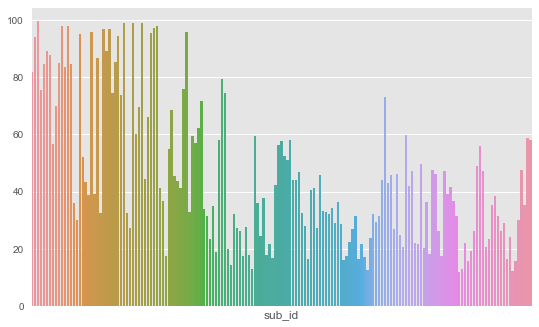

In [535]:
plt.style.use('ggplot')

xval, yval = success_rate(kickstarter, 'sub_id').index, success_rate(kickstarter, 'sub_id').values
sns.barplot(x=xval, y=yval)
plt.xticks([])
plt.show()

At present, the subcategories are labeled only by their sub_id number.  Since I'm curious about which specific categories are doing well and which are not, I construct a dictionary that decodes sub_id into the recognizable subcategory it represents.

In [430]:
# Create a dictionary that takes in a valid sub_id number and converts it to the corresponding subcategory name #
CODES = training_rough['category'].map(lambda x: json.loads(x)['id'])
SUBCATS = training_rough['category'].map(lambda x: json.loads(x)['name'])

sub_id_decoder = dict(zip(CODES, SUBCATS))

In [432]:
# Adding the subcategory name column to the dataframe #
kickstarter['sub'] = kickstarter['sub_id'].map(lambda x: sub_id_decoder[x])

<br>
Now that I have the names of the subcategories, I'd like to take a look at which are most and least successful.  The top 10 of each are displayed below.

In [433]:
# Finding the top 10 most successful subcategories
top = success_rate(kickstarter, 'sub_id').sort_values(ascending=False)[:10]
top_index = top.index.map(lambda x: sub_id_decoder[x])

# Finding the top 10 most unsuccessful subcategories
bot = success_rate(kickstarter, 'sub_id').sort_values(ascending=True)[1:11]
bot_index = bot.index.map(lambda x: sub_id_decoder[x])

# Web has two sub_ids that link to it, so I neglect the first one at index 0 for visual clarity #

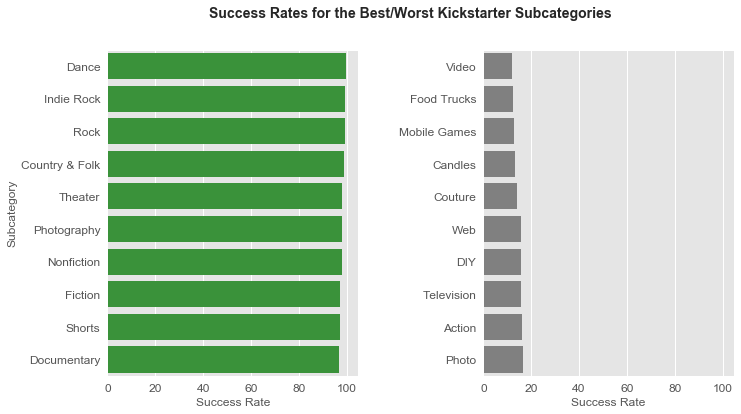

In [438]:
# Plotting the Top 10 (left) and Bottom 10 (right) Subcategories by success rate #

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=[10, 6], sharex=True)

sns.barplot(top, top_index, orient='h', color=tableau20[4], ax=ax0)
sns.barplot(bot, bot_index, orient='h', color='grey', ax=ax1)

ax0.set(ylabel='Subcategory', xlabel='Success Rate')
ax1.set(ylabel='', xlabel='Success Rate')
ax0.tick_params(axis='both', which='major', labelsize=12)
ax1.tick_params(axis='both', which='major', labelsize=12)
fig.suptitle('Success Rates for the Best/Worst Kickstarter Subcategories', fontsize=14, fontweight='bold')    
plt.subplots_adjust(wspace=0.5)

plt.show()

#### How do subcategory success rates vary within the same parent category?

It appears that the success rate depends on both the parent cateogry and the subcategory.  It's worth examining whether these features are redundant.  To do so qualitatively, I'll examine the subcategory success rates throughout the same parent category.

In [440]:
# Selecting a few parent_ids #
ks_success_agg_by_id = \
kickstarter[kickstarter['status']=='successful'].groupby(['parent_id', 'sub']).agg(['mean', 'count'])

ks_failure_agg_by_id = \
kickstarter[kickstarter['status']=='failed'].groupby(['parent_id', 'sub']).agg(['mean', 'count'])

ks_success_agg_by_id.query('10 < parent_id < 15').head(2)

goal       backers_count         duration        \
                             mean count          mean count       mean count   
parent_id sub                                                                  
11        Action     12673.057554   139    256.266187   139  29.330935   139   
          Animation  50004.903599   778    404.080977   778  33.469152   778   

                       creator_id         usd_pledged        ...  \
                             mean count          mean count  ...   
parent_id sub                                                ...   
11        Action     1.163739e+09   139  18129.921694   139  ...   
          Animation  1.111975e+09   778  30831.754661   778  ...   

                    year_launched       month_launched       funding_fraction  \
                             mean count           mean count             mean   
parent_id sub                                                                   
11        Action      2015.985612   139       6.582734   139         3.063462   
          Animation   2014.159383   778       6.209512   778         9.384973   

                            daily_goal        log_goal        
                    count         mean count      mean count  
parent_id sub                                                 
11        Action      139   422.988053   139  7.916266   139  
          Animation   778  1528.041429   778  8.515806   778  

[2 rows x 28 columns]

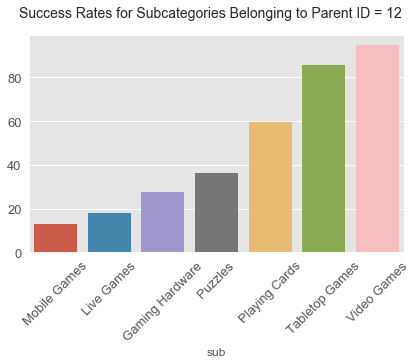

In [448]:
fig, ax = plt.subplots()

suc = success_rate(kickstarter[kickstarter['parent_id'] == 12], 'sub').sort_values()
labels = suc.index
values = suc.values

sns.barplot(labels, values)
ax.tick_params(axis='both', which='major', labelsize=13)
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
fig.suptitle('Success Rates for Subcategories Belonging to Parent ID = 12', fontsize=14)
plt.show()

I'm lastly interested in the success rate for various subcategories belonging to the "Films" parent category.  There appears to be substantial variance of success rate by subcategory within the same category, which probably means that parent_id is too noisy to be predictive.

To visualize another potential relationship, mean funding goal is plotted for each subcategory along with its success rate.

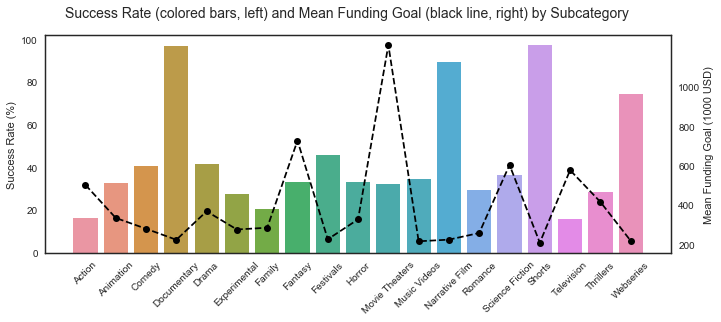

In [478]:
# Briefly switch styles back to sns white #
plt.style.use('seaborn')
plt.style.use('seaborn-white')

fig, ax1 = plt.subplots(figsize=[10,4])
ax2 = ax1.twinx()

# Pick out the parent_id assocaited with Film #
suc = success_rate(kickstarter[kickstarter['parent_id'] == 11], 'sub')
labels = suc.index
values = suc.values

# Plot the success rate (left) #
sns.barplot(x=labels, y=values, ax=ax1)

# Create the aggregate 'mean_goal' and plot it in black (left axis)#
mean_goal = kickstarter[kickstarter.parent_id == 11].groupby('sub').agg('mean')['goal']

ax2.plot(mean_goal.index, mean_goal.values, marker='o', linestyle='dashed', color='k', label='Mean Goal')

# Rotate ticks to make some room    
for tick in ax1.get_xticklabels():
        tick.set_rotation(45)
        
ax1.set_xlabel('')
ax1.set_ylabel('Success Rate (%)')
ax2.set_ylabel('Mean Funding Goal (1000 USD)')
ax2.set_yticklabels(['0', '200', '400', '600', '800', '1000'], minor=False)

fig.suptitle('Success Rate (colored bars, left) and Mean Funding Goal (black line, right) by Subcategory', fontsize=14)
plt.show()

#### Duration, Number of Words, City

Duration and number of words have pretty distinct patterns that can be recognized.

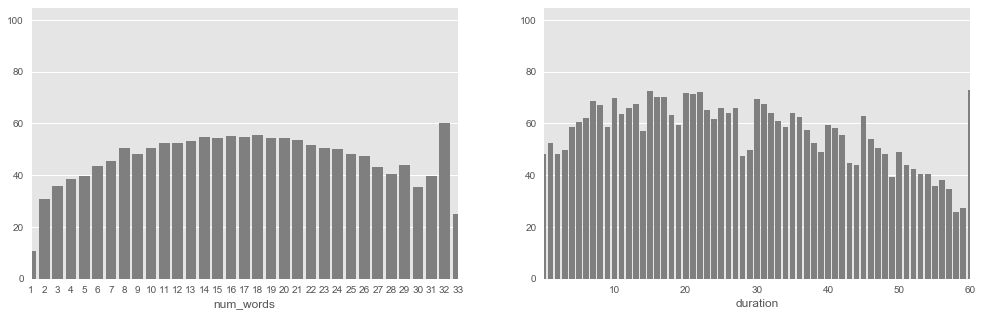

In [531]:
plt.style.use('ggplot')
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=([15, 5]))

suc1 = success_rate(kickstarter, 'num_words')
sns.barplot(x=suc1.index, y=suc1.values, color=tableau20[14], ax=ax0)
# We will neglect word counts of 32-35 due to low statistics (only 6 projects fit here) #
ax0.set_xlim([0, 32])

suc2 = success_rate(kickstarter, 'duration')
sns.barplot(x=suc2.index, y=suc2.values, color=tableau20[14], ax=ax1)
# I neglect durations beyond 60 due to low statistics (less than 0.05%)
ax1.set_xlim([0, 60])
ax1.set_xticks([10, 20, 30, 40, 50, 60])
ax1.set_xticklabels([10, 20, 30, 40, 50, 60])

plt.show()

The success rate given the number of words in the blurb has a sweet-spot around 17 to 18 words -- not too long, not too short.  Duration is a bit less clear, but it appears that shorter is better.

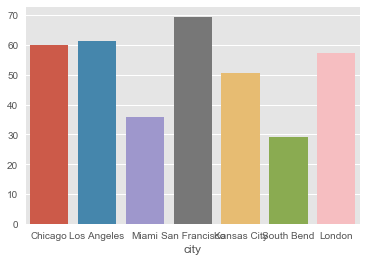

In [264]:
suc = success_rate(kickstarter, 'city')
selection = ['Chicago', 'Los Angeles', 'Miami', 'San Francisco', 'Kansas City', 'South Bend', 'London']
sns.barplot(suc[selection].index, suc[selection].values)

plt.show()

### How Do These Features Vary With Time?

<br>

As a final step in EDA, I'll examine the time dependence of a few important parameters including success rate, number of backers per time period, and the amount pledged per time period.

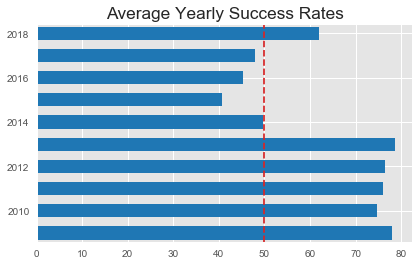

In [340]:
plt.barh(y =success_rate(kickstarter, 'year_launched').index, width = success_rate(kickstarter, 'year_launched'), height=0.6, color=tableau20[0])
plt.axvline(50, color=tableau20[6], linestyle='--')

plt.ylim([2008.6, 2018.4])
plt.title('Average Yearly Success Rates')
plt.show()

In [78]:
kick_backers = kickstarter.copy()
kick_backers.columns = ['goal', 'backers_count', 'duration', 'creator_id', 'status',
       'pledged', 'quarter', 'parent', 'sub_id', 'num_words', 'city', 'state',
       'weekday', 'year', 'month',
       'funding_fraction', 'daily_goal', 'sub']

In [79]:
kick_backers_quarterly = kickstarter.groupby(['sub_id', 'quarter', 'year_launched']).sum()[['backers_count']]
kick_backers_quarterly.reset_index(inplace=True)
kick_backers_quarterly.columns = ['sub_id', 'quarter', 'year', 'sub_qtr_backers']

kick_backers_quarterly_parent = kickstarter.groupby(['parent_id', 'quarter', 'year_launched']).sum()[['backers_count']]
kick_backers_quarterly_parent.reset_index(inplace=True)
kick_backers_quarterly_parent.columns = ['parent', 'quarter', 'year', 'parent_qtr_backers']

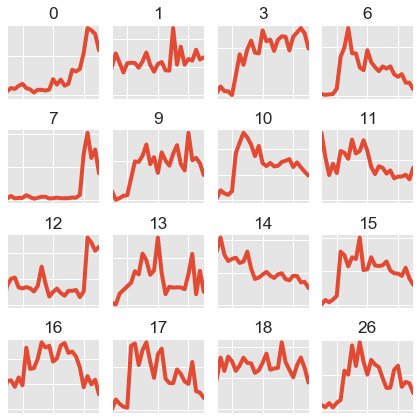

In [417]:
fig, ax = plt.subplots(4, 4, figsize=(6,6), sharex=True)

for i in range(4):
    for j in range(4):
        ID = kick_backers_quarterly_parent['parent'].unique()[4*i + j]
        examp2 = kick_backers_quarterly_parent[kick_backers_quarterly_parent['parent'] == ID]
        x_vals = (examp2.year.values) + (examp2.quarter.values - 1)/4
        y_vals = examp2.parent_qtr_backers.values
        sns.lineplot(x_vals, y_vals, ax=ax[i, j])
        #turn_off_spines(ax[i,j])
        ax[i,j].set_yticklabels([])
        ax[i,j].set_xticklabels([])
        ax[i,j].set_title(ID)
        
plt.tight_layout()
plt.xlim([2013, 2019])
plt.show()

In [80]:
backers_by_qtr = kickstarter.groupby(['quarter', 'year_launched']).sum()[['backers_count']]
backers_by_qtr.reset_index(inplace=True)
backers_by_qtr.columns = ['quarter', 'year', 'backers_in_qtr']

goal_by_qtr = kickstarter.groupby(['quarter', 'year_launched']).sum()[['goal']]
goal_by_qtr.reset_index(inplace=True)
goal_by_qtr.columns = ['quarter', 'year', 'goal_qtr']

qtr_pledge_tot = kickstarter.groupby(['quarter', 'year_launched']).sum()[['usd_pledged']]
qtr_pledge_tot.reset_index(inplace=True)
qtr_pledge_tot.columns = ['quarter', 'year', 'pledged_in_qtr']

proj_per_qtr = kickstarter.groupby(['quarter', 'year_launched']).count()[['status']]
proj_per_qtr.reset_index(inplace=True)
proj_per_qtr.columns = ['quarter', 'year', 'proj_per_qtr']

In [81]:
kick_backers = pd.merge(kick_backers, kick_backers_quarterly, on=['sub_id', 'quarter', 'year'], how='left')
kick_backers = pd.merge(kick_backers, backers_by_qtr, on=['quarter', 'year'], how='left')
kick_backers = pd.merge(kick_backers, goal_by_qtr, on=['quarter', 'year'], how='left')
kick_backers = pd.merge(kick_backers, kick_backers_quarterly_parent, on=['parent', 'quarter', 'year'], how='left')
kick_backers = pd.merge(kick_backers, qtr_pledge_tot, on=['quarter', 'year'], how='left')
kick_backers = pd.merge(kick_backers, proj_per_qtr, on=['quarter', 'year'], how='left')

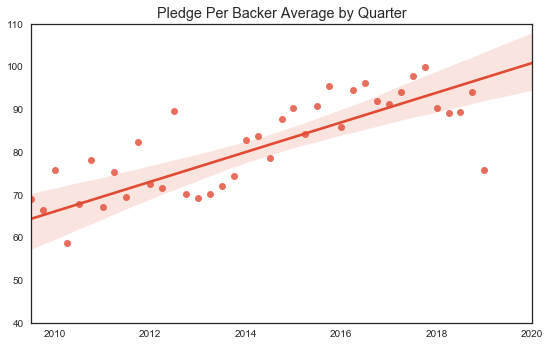

In [351]:
pledge_backer_qtr_df = kick_backers.groupby(['year', 'quarter']).mean()[['pledged_in_qtr', 'backers_in_qtr']]
pledged_per_backer_in_qtr = pledge_backer_qtr_df.pledged_in_qtr / pledge_backer_qtr_df.backers_in_qtr

x = np.arange(start, end + interval, interval) #from above definition#
sns.regplot(x=x, y=pledged_per_backer_in_qtr.values)

plt.xlim([2009.5, 2020])
plt.ylim([40, 110])
plt.title('Pledge Per Backer Average by Quarter')
plt.show()

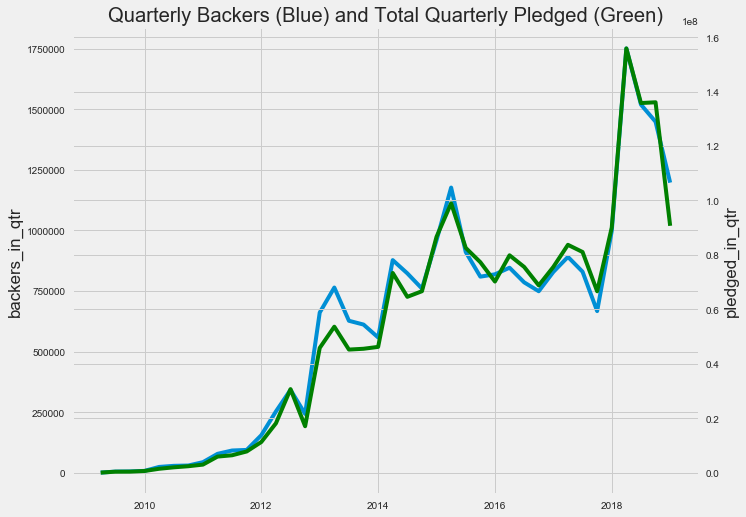

In [352]:
plt.style.use('fivethirtyeight')

fig, ax1 = plt.subplots(figsize=(10, 8))
ax2 = ax1.twinx()

x1_vals = backers_by_qtr.year + (backers_by_qtr.quarter-1) / 4
y1_vals = backers_by_qtr.backers_in_qtr

x2_vals = qtr_pledge_tot.year + (qtr_pledge_tot.quarter-1)/4
y2_vals = qtr_pledge_tot.pledged_in_qtr

sns.lineplot(x1_vals, y1_vals, ax=ax1)
sns.lineplot(x2_vals, y2_vals, ax=ax2, color='green')

plt.title('Quarterly Backers (Blue) and Total Quarterly Pledged (Green)')
plt.show()

# Not surprising they are so close as the amount pledged is expected to be proportional to one of the fixed reward options offered

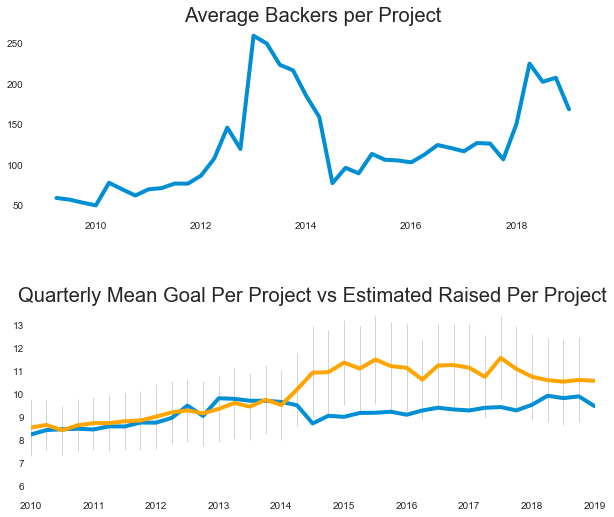

In [353]:
plt.style.use('seaborn-white')

backers_per_project_in_quarter = backers_by_qtr.sort_values(by=['year', 'quarter']).backers_in_qtr / proj_per_qtr.sort_values(by=['year', 'quarter']).proj_per_qtr
goal_per_project_in_quarter = goal_by_qtr.sort_values(by=['year', 'quarter']).goal_qtr / proj_per_qtr.sort_values(by=['year', 'quarter']).proj_per_qtr

kickstarter['log_goal'] = kickstarter['goal'].map(lambda x: np.log1p(x))
goal_std = kickstarter.groupby(['year_launched', 'quarter'])['log_goal'].std()
backers_std = kickstarter.groupby(['year_launched', 'quarter'])['backers_count'].std()

fig, ax1 = plt.subplots(2, 1, figsize=(9,8))
ax2 = ax1[1]
fig.subplots_adjust(hspace=0.5)

qtrs = len(backers_by_qtr.quarter)
start = 2009 + 0.25
end = 2019.00
interval = 0.25

sns.lineplot(x = np.arange(start, end + interval, interval), y=backers_per_project_in_quarter, ax=ax1[0])
ax1[0].set_title('Average Backers per Project')

# Combining average backer pledge and average number of backers to compare to average goal #
average_pledged_calc = backers_per_project_in_quarter * pledged_per_backer_in_qtr.values
sns.lineplot(x = np.arange(start, end + interval, interval), y=np.log1p(average_pledged_calc), ax=ax2)
#sns.lineplot(x = np.arange(start, end + interval, interval), y=np.log1p(goal_per_project_in_quarter), color='orange', alpha=0.7, ax=ax2)

plt.xlim([2010, 2019])
ax2.errorbar(np.arange(start, end + interval, interval), y=np.log1p(goal_per_project_in_quarter), color='orange', yerr = goal_std.values, ecolor='lightgrey', elinewidth=1)
ax2.set_title('Quarterly Mean Goal Per Project vs Estimated Raised Per Project')

turn_off_spines(ax1[0])
turn_off_spines(ax2)

plt.show()

# 7.) Feature Engineering

Note that removing all id duplicates (repeat entries) also removed all extra copies of creator_id (with the exception of creator_id 0 which is just an unlabeled creator).  Since it is unique for every data entry, creator_id cannot be predictive so we drop it from our categories.

What about number of backers per month per category?  Is it constant?  Is a rate constant?  Are you competing against your own category?

In [287]:
df_ks = kickstarter.copy()
df_ks = df_ks[df_ks['status'] != 'live']
drop_cols = ['creator_id']
df_ks.drop(columns=drop_cols, inplace=True)
df_ks['status'] = df_ks['status'].apply(lambda x: 1 if x == 'successful' else 0)

Rename backers and impute 0 values as 1 so we can do division without trouble.

In [288]:
df_ks.rename(columns={"backers_count":"backers", "usd_pledged": "pledged"}, inplace=True)
df_ks.loc[df_ks['backers'] == 0, 'backers'] = 1

df_ks.loc[:, 'pledge_per_backer'] = df_ks['pledged'] / df_ks['backers']

Create two new columns that place project goal and duration into bins based on the subcategory's distribution.  The last duplicates drop is necessary to get rid of repeated bin edges.

In [289]:
df_ks['goal_pct_by_subcat'] = df_ks.groupby(['sub'])['goal'].transform(lambda x: pd.qcut(x, 3, labels=[1,2,3]))

df_ks['duration_by_subcat'] = df_ks.groupby(['sub'])['duration'].transform(lambda x: pd.qcut(x, 3, labels=False, duplicates='drop'))

Will continue with just a few more engineered metrics to help form the relations: competitors/quarter, competitors/launch month, and avg pledged / backer and success rate per goal, etc in year.

We start by forming the avg number of competitors by month/year for the subcategories in the same goal bucket:

In [290]:
competitors_monthly = df_ks.groupby(['sub', 'month_launched', \
                                      'year_launched', 'goal_pct_by_subcat']).count()

competitors_monthly = competitors_monthly[['status']]
competitors_monthly.reset_index(inplace=True)
competitors_monthly.columns = ['sub', 'month_launched','year_launched', \
                               'goal_pct_by_subcat', 'competitors_monthly']

In [291]:
avg_pledge_by_goal = pd.DataFrame(df_ks.groupby(['sub', 'year_launched', 'goal_pct_by_subcat'])\
                          ['pledge_per_backer', 'funding_fraction'].mean())
avg_pledge_by_goal.reset_index(inplace=True)
avg_pledge_by_goal.columns = ['sub', 'year_launched', 'goal_pct_by_subcat', 'avg_ppb', 'avg_fraction_goal']

Do same thing but based on duration bin rather than goal_amt bin

In [292]:
avg_pledge_by_duration = pd.DataFrame(df_ks.groupby(['sub', 'year_launched', 'duration_by_subcat'])\
                          ['funding_fraction'].mean())
avg_pledge_by_duration.reset_index(inplace=True)
avg_pledge_by_duration.columns = ['sub', 'year_launched', 'duration_by_subcat', 'avg_fraction_dur']

Finally, let's create a reference subcategory average goal so that project goal ambition can be inferred

In [293]:
avg_goal = pd.DataFrame(df_ks.groupby(['sub', 'year_launched', 'duration_by_subcat'])['goal'].mean().astype(int))
avg_goal.reset_index(inplace=True)
avg_goal.columns = ['sub', 'year_launched', 'duration_by_subcat', 'avg_goal']

In [294]:
df_ks['log_goal'] = np.log1p(df_ks['goal'])

Merging the newly constructed dataframes with the original

In [295]:
df_ks = pd.merge(df_ks, competitors_monthly, on = \
                ['sub', 'year_launched', 'month_launched', 'goal_pct_by_subcat'], how= 'left')

df_ks = pd.merge(df_ks, avg_pledge_by_goal, on = ['sub', 'year_launched', 'goal_pct_by_subcat'], how='left')

df_ks = pd.merge(df_ks,avg_pledge_by_duration, on = ['sub', 'year_launched', 'duration_by_subcat'], how='left')

df_ks = pd.merge(df_ks, avg_goal, on=['sub', 'year_launched', 'duration_by_subcat'], how='left')

In [296]:
df_ks_copy = df_ks.copy()

# Subcategory success across time

It seems that specific user groups are driven toward Kickstarter and that topics related to those groups do very well.  Let's see if, over the course of the data, Kickstarter's user base has changed.  Let's track if the average goal pct obtained changes over time.

NOTE: Need to find these averages using training data only to prevent data leakage.

# Random Forest Model (no one-hot encoding)

I try this again without one-hot encoding, which likely hurts tree-based methods

In [302]:
dropping = ['backers', 'pledged', 'state', 'pledge_per_backer', 'sub', 'city', 'funding_fraction']

df_ks_copy.drop(dropping, axis=1, inplace=True)

y = df_ks_copy['status']
X = df_ks_copy.drop('status', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [316]:
clf = RandomForestClassifier(n_estimators = 20, criterion = 'gini',\
max_depth = 12, max_features=6, random_state=250)

RFModel = clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

print('train accuracy is', accuracy_score(y_train, y_train_pred) \
      ,'and test accuracy is', accuracy_score(y_test, y_test_pred))

train accuracy is 0.8283072365320306 and test accuracy is 0.7944655160805261


The naive feature importance from our Random Forest Model is given as follows:

In [317]:
feat_importance = pd.DataFrame(list(zip(X, clf.feature_importances_)))

feat_importance.sort_values(1, ascending=False)

,0,1
15,avg_fraction_goal,0.368667
16,avg_fraction_dur,0.181977
4,sub_id,0.122949
17,avg_goal,0.079895
14,avg_ppb,0.050276
0,goal,0.039002
1,duration,0.025948
9,daily_goal,0.023901
10,log_goal,0.019711
3,parent_id,0.016296


More robustly, we use permutation importance to better assess feature importance.  This will essentially take into account the effect of mixing up feature values.  The more predictive features should be highly sensitive to interchanging arbitrary rows/entries.

In [158]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(RFModel, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.1380 ± 0.0037,avg_fraction_goal
0.0658 ± 0.0028,avg_fraction_dur
0.0169 ± 0.0017,sub_id
0.0125 ± 0.0007,avg_ppb
0.0095 ± 0.0010,avg_goal
0.0086 ± 0.0009,duration
0.0030 ± 0.0004,competitors_monthly
0.0030 ± 0.0009,year_launched
0.0028 ± 0.0014,log_goal
0.0026 ± 0.0011,goal


### Precision, recall, and the corresponding confusion matrix offer a more detailed picture of how our model is actually doing:

In [318]:
Table = confusion_matrix(y_test, y_test_pred)

for line in Table:
    print(*line)

17704 3140
6018 17695


In [319]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.75      0.85      0.79     20844
           1       0.85      0.75      0.79     23713

   micro avg       0.79      0.79      0.79     44557
   macro avg       0.80      0.80      0.79     44557
weighted avg       0.80      0.79      0.79     44557



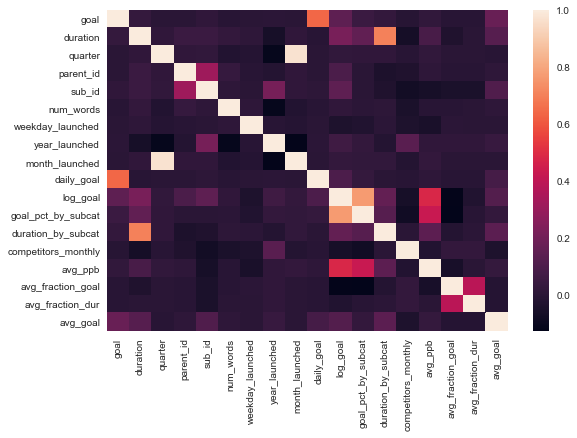

In [320]:
sns.heatmap(X.corr())
plt.show()

### What have we learned from this?

If you wish to invest in a Kickstarter, you should stick to the subcategories with recent success and beware of categories that have had difficulty meeting their goals.

Throughout, look for projects with shorter durations and smaller goals.

If interested in creating a Kickstarter project, apart from what has been mentioned above, it seems there is a slight improvement when between 14 and 22 words are used in the description--it shouldn't be too short nor too long.  Adding additional pictures seems to help consistently from preliminary analysis.


This project can be improved by adding in updated Kickstarter data, eliminating data leakage from feature engineering (restricting aggregations to training data), studying model drift, and adding in additional features scraped from Kickstarter (number of pictures, rewards for backers).